In [73]:
!pip install gym[atari]
!pip install tensorflow

In [74]:
!pip install gym[accept-rom-license]

In [75]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from collections import deque
import random
import cv2  # библиотека для обработки изображений
import matplotlib.pyplot as plt

# Установка отображения графиков в Colab
%matplotlib inline


In [76]:
# Создание среды Atari
env = gym.make('CartPole-v1')

# Определение размера буфера опыта
buffer_size = 10000
batch_size = 32
memory = deque(maxlen=buffer_size)

In [77]:
# Определение формы ввода и количества действий
input_shape = (4,)
num_actions = env.action_space.n

# Создание нейронной сети Q-сети
def create_q_network():
    model = Sequential([
        Dense(32, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_actions)
    ])
    return model

q_network = create_q_network()
target_network = create_q_network()
target_network.set_weights(q_network.get_weights())


In [78]:
# Определение функции потерь и оптимизатора
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

def loss_function(target, predicted):
    return tf.reduce_mean(tf.square(target - predicted))



In [79]:
# Определение параметров ε-жадной стратегии
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.999

def epsilon_greedy_policy(state):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_network.predict(state))


In [80]:
# Определение функции для выборки батчей из буфера опыта
def sample_batch(memory, batch_size):
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# Компиляция модели
q_network.compile(optimizer=optimizer, loss='mse')

In [82]:
# Обучение
num_episodes = 50
gamma = 0.99
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    while True:
        state = np.expand_dims(state, axis=0)
        action = epsilon_greedy_policy(state)
        next_state, reward, done, _ = env.step(action)

        total_reward += reward

        memory.append((state.flatten(), action, reward, next_state.flatten(), done))

        state = next_state

        if len(memory) >= batch_size:
            states, actions, rewards, next_states, dones = sample_batch(memory, batch_size)

            target_values = rewards + gamma * np.max(target_network.predict(next_states), axis=1) * (1 - dones)
            q_values = q_network.predict(states)
            q_values[range(batch_size), actions] = target_values

            q_network.train_on_batch(states, q_values)

            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

        if done:
            break

    episode_rewards.append(total_reward)

    if (episode + 1) % 10 == 0:
        target_network.set_weights(q_network.get_weights())

    print(f"Эпизод: {episode + 1}, Общая награда: {total_reward}")

Эпизод: 1, Общая награда: 14.0
Эпизод: 2, Общая награда: 17.0
1/1 [==============================] - 0s 54ms/step
Эпизод: 3, Общая награда: 23.0
1/1 [==============================] - 0s 125ms/step
Эпизод: 4, Общая награда: 30.0
1/1 [==============================] - 0s 21ms/step
Эпизод: 5, Общая награда: 16.0
1/1 [==============================] - 0s 21ms/step
Эпизод: 6, Общая награда: 37.0
1/1 [==============================] - 0s 20ms/step
Эпизод: 7, Общая награда: 13.0
1/1 [==============================] - 0s 20ms/step
Эпизод: 8, Общая награда: 35.0
1/1 [==============================] - 0s 19ms/step
Эпизод: 9, Общая награда: 11.0
1/1 [==============================] - 0s 18ms/step
Эпизод: 10, Общая награда: 14.0
1/1 [==============================] - 0s 19ms/step
Эпизод: 11, Общая награда: 11.0
1/1 [==============================] - 0s 27ms/step
Эпизод: 12, Общая награда: 15.0
1/1 [==============================] - 0s 23ms/step
Эпизод: 13, Общая награда: 42.0
1/1 [===============

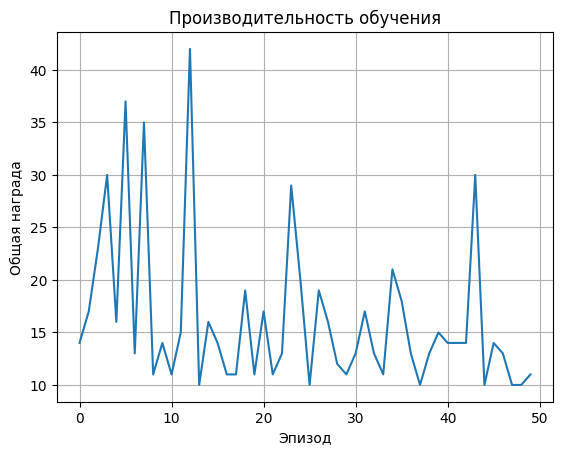

In [83]:
# Визуализация производительности обучения
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Общая награда')
plt.title('Производительность обучения')
plt.grid(True)
plt.show()
